In [ ]:
pip install plotly pandas

# Data Understanding

In [ ]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/bebekgarut/SOM-country-data/refs/heads/main/Country-data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# Data Preprocessing

Drop kolom exports dan imports karena tidak dibutuh untuk menghitung kesejahteraan rakyat

In [ ]:
data.drop(columns=['exports', 'imports'],inplace=True, axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   health      167 non-null    float64
 3   income      167 non-null    int64  
 4   inflation   167 non-null    float64
 5   life_expec  167 non-null    float64
 6   total_fer   167 non-null    float64
 7   gdpp        167 non-null    int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 10.6+ KB


Cek outlier

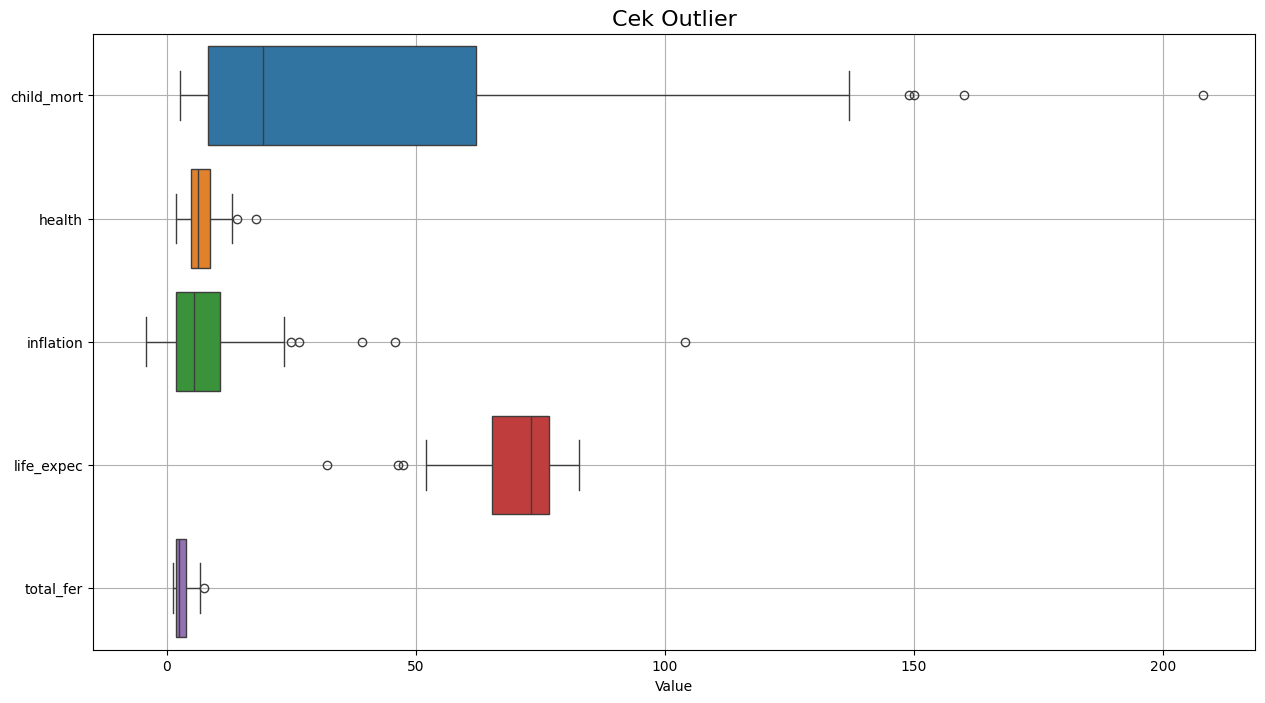

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['child_mort', 'health', 'inflation', 'life_expec', 'total_fer']
plt.figure(figsize=(15, 8))
sns.boxplot(data=data[columns], orient="h")
plt.title('Cek Outlier', fontsize=16)
plt.xlabel('Value')
plt.grid(True)
plt.show()

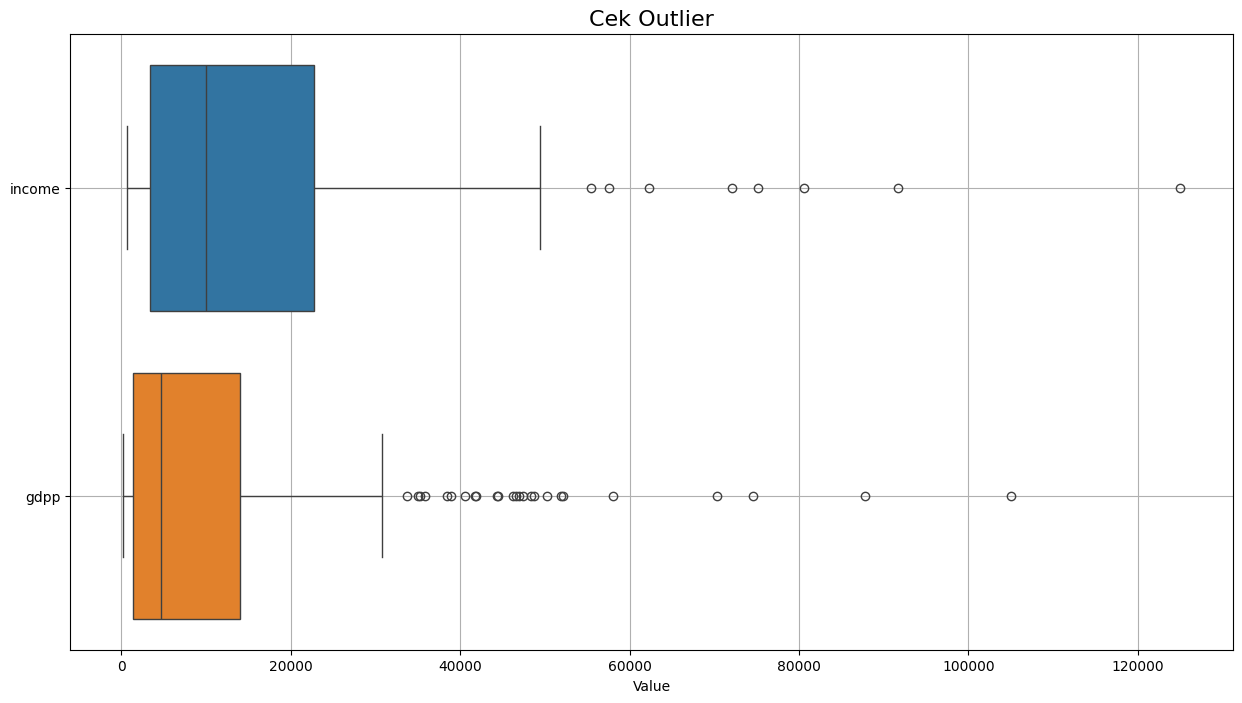

In [ ]:
columns = ['income', 'gdpp']
plt.figure(figsize=(15, 8))
sns.boxplot(data=data[columns], orient="h")
plt.title('Cek Outlier', fontsize=16)
plt.xlabel('Value')
plt.grid(True)
plt.show()

Karena banyaknya outlier maka untuk normalisasi data menggunakan RobustScaler

Simpan kolom country lalu hapus untuk melakukan training

In [ ]:
country_name = data['country']
data.drop(columns=['country'],inplace=True, axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   health      167 non-null    float64
 2   income      167 non-null    int64  
 3   inflation   167 non-null    float64
 4   life_expec  167 non-null    float64
 5   total_fer   167 non-null    float64
 6   gdpp        167 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 9.3 KB


Normalisasi data dengan RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_array = scaler.fit_transform(data)

data = pd.DataFrame(scaled_array, columns=data.columns)

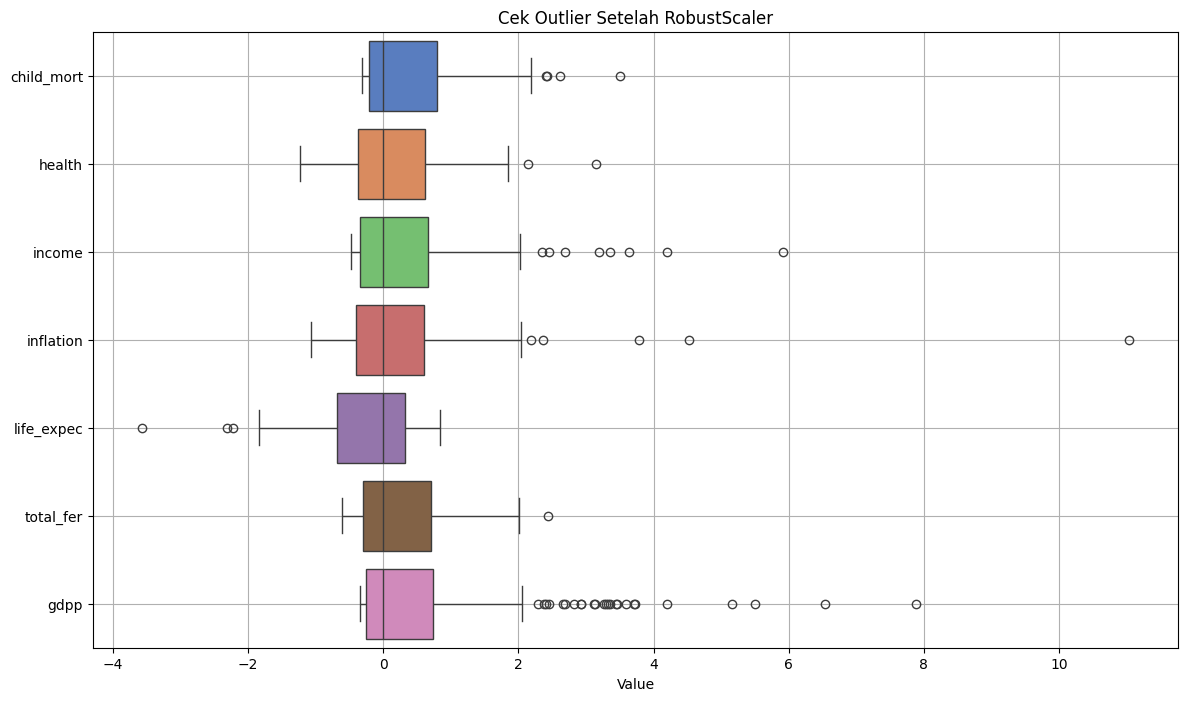

In [ ]:
plt.figure(figsize=(14,8))
sns.boxplot(data=data, orient="h", palette="muted")
plt.title("Cek Outlier Setelah RobustScaler")
plt.xlabel("Value")
plt.grid(True)
plt.show()

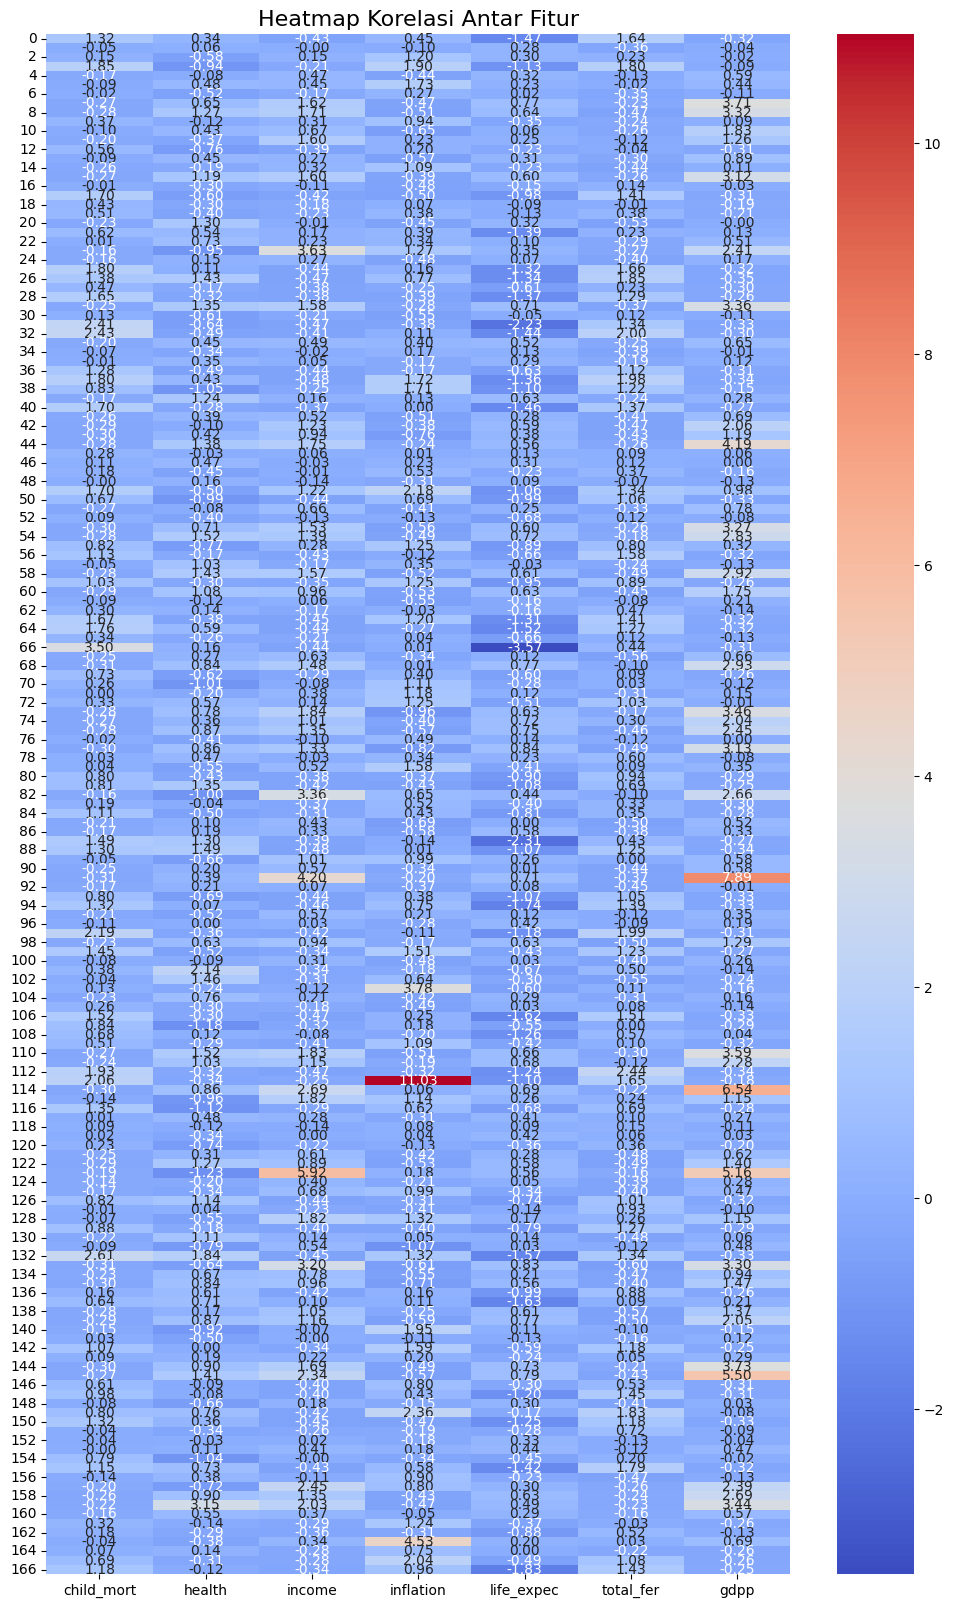

In [ ]:
plt.figure(figsize=(12, 20))
sns.heatmap(data=data, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Fitur', fontsize=16)
plt.show()

In [ ]:
data.head()

,child_mort,health,income,inflation,life_expec,total_fer,gdpp
0,1.316620,0.342391,-0.429416,0.453020,-1.469565,1.635492,-0.322877
1,-0.050139,0.062500,-0.001543,-0.100671,0.278261,-0.364508,-0.044811
2,0.148561,-0.584239,0.151196,1.197987,0.295652,0.230216,-0.015723
3,1.851439,-0.942935,-0.208794,1.902685,-1.130435,1.798561,-0.088836
4,-0.167131,-0.078804,0.470044,-0.441834,0.321739,-0.134293,0.592767


# Model Development

In [ ]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=625e18fb502945c05d120016b1254c510148fc29f69091fc69c83ae12e9e25c2
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.metrics import silhouette_score

data_train = data.values

som = MiniSom(x=1, y=3, input_len=7, learning_rate=0.3, sigma=0.01, random_seed=42)

som._weights = np.array([[
    [0.426484907,0.358607831,0.008047206,0.12614361,0.475345168,0.73659306,0.003073428],
    [0.182083739,0.770043505,0.021954965,0.074022734,0.656804734,0.364353312,0.0250933],
    [0.012658228,0.486637663,0.286121986,0.053414657,0.950690335,0.121451104,0.369088184]
]])

for iter_num in range(50):
    for idx, sample in enumerate(data_train):
        winner = som.winner(sample)
        som.update(sample, winner, idx + iter_num * len(data_train), 7 * len(data_train))

clusters = np.array([som.winner(d)[1] for d in data_train])

silhouette = silhouette_score(data_train, clusters)

print("=== Hasil Clustering ===")
for name, cluster in zip(country_name, clusters):
    print(f"{name}: Cluster {cluster}")
print("Silhouette Score:", silhouette)

=== Hasil Clustering ===
Afghanistan: Cluster 0
Albania: Cluster 1
Algeria: Cluster 1
Angola: Cluster 0
Antigua and Barbuda: Cluster 1
Argentina: Cluster 1
Armenia: Cluster 1
Australia: Cluster 2
Austria: Cluster 2
Azerbaijan: Cluster 1
Bahamas: Cluster 1
Bahrain: Cluster 1
Bangladesh: Cluster 1
Barbados: Cluster 1
Belarus: Cluster 1
Belgium: Cluster 2
Belize: Cluster 1
Benin: Cluster 0
Bhutan: Cluster 1
Bolivia: Cluster 1
Bosnia and Herzegovina: Cluster 1
Botswana: Cluster 0
Brazil: Cluster 1
Brunei: Cluster 2
Bulgaria: Cluster 1
Burkina Faso: Cluster 0
Burundi: Cluster 0
Cambodia: Cluster 1
Cameroon: Cluster 0
Canada: Cluster 2
Cape Verde: Cluster 1
Central African Republic: Cluster 0
Chad: Cluster 0
Chile: Cluster 1
China: Cluster 1
Colombia: Cluster 1
Comoros: Cluster 0
Congo, Dem. Rep.: Cluster 0
Congo, Rep.: Cluster 0
Costa Rica: Cluster 1
Cote d'Ivoire: Cluster 0
Croatia: Cluster 1
Cyprus: Cluster 2
Czech Republic: Cluster 1
Denmark: Cluster 2
Dominican Republic: Cluster 1
Ecuad

In [ ]:
import pandas as pd

# Buat DataFrame dari hasil cluster
df_result = pd.DataFrame(data_train, columns=data.columns)
df_result['Cluster'] = clusters

# Tambahkan silhouette score sebagai sheet terpisah
with pd.ExcelWriter('hasil_som.xlsx', engine='openpyxl') as writer:
    df_result.to_excel(writer, sheet_name='Cluster_Result', index=False)
    # Sheet terpisah untuk silhouette score
    pd.DataFrame({'Silhouette Score': [silhouette]}).to_excel(writer, sheet_name='Silhouette', index=False)

print("Berhasil diekspor ke 'hasil_som.xlsx'")


Berhasil diekspor ke 'hasil_som.xlsx'


# Data Understanding V2

In [ ]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/bebekgarut/SOM-country-data/refs/heads/main/world-data-2023.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                            195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    object 
 10  CPI                       

# Data Preprocessing

In [ ]:
selected_columns = [
    'Country',
     'Fertility Rate',
    'Infant mortality',
      'Life expectancy',
    'Maternal mortality ratio',
    'Out of pocket health expenditure',
    'Physicians per thousand',
]
data = data[selected_columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           195 non-null    object 
 1   Fertility Rate                    188 non-null    float64
 2   Infant mortality                  189 non-null    float64
 3   Life expectancy                   187 non-null    float64
 4   Maternal mortality ratio          181 non-null    float64
 5   Out of pocket health expenditure  188 non-null    object 
 6   Physicians per thousand           188 non-null    float64
dtypes: float64(5), object(2)
memory usage: 10.8+ KB


In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
3,Andorra,1.27,2.7,NaN,NaN,36.40%,3.33
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
48,Dominica,1.90,32.9,76.6,NaN,28.40%,1.08
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
107,Marshall Islands,4.05,27.4,65.2,NaN,10.00%,0.42
113,Monaco,NaN,2.6,NaN,NaN,6.10%,6.56
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67


**Maternal mortality ratio**
>  Andorra : 11.2 (https://data.who.int/indicators/i/C071DCB/AC597B1)

>  Dominica : 35.5 (https://data.who.int/indicators/i/C071DCB/AC597B1)

>  Marshall Islands : 154.8(https://data.who.int/indicators/i/C071DCB/AC597B1)

>  Monaco : 5.2 (https://data.who.int/indicators/i/C071DCB/AC597B1)

>  North Macedonia : 2.8 (https://data.who.int/indicators/i/C071DCB/AC597B1)

>  Palau : 89.4 (https://data.who.int/indicators/i/C071DCB/AC597B1)

>  San Marino : 7.7 (https://data.who.int/indicators/i/C071DCB/AC597B1)

>  Tuvalu : 169.7 (https://data.who.int/indicators/i/C071DCB/AC597B1)

In [ ]:
data.loc[data['Country'] == 'Andorra', 'Maternal mortality ratio'] = 11.2
data.loc[data['Country'] == 'Dominica', 'Maternal mortality ratio'] = 35.5
data.loc[data['Country'] == 'Marshall Islands', 'Maternal mortality ratio'] = 154.8
data.loc[data['Country'] == 'Monaco', 'Maternal mortality ratio'] = 5.2
data.loc[data['Country'] == 'North Macedonia', 'Maternal mortality ratio'] = 2.8
data.loc[data['Country'] == 'Palau', 'Maternal mortality ratio'] = 89.4
data.loc[data['Country'] == 'San Marino', 'Maternal mortality ratio'] = 7.7
data.loc[data['Country'] == 'Tuvalu', 'Maternal mortality ratio'] = 169.7

In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
3,Andorra,1.27,2.7,NaN,11.2,36.40%,3.33
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
113,Monaco,NaN,2.6,NaN,5.2,6.10%,6.56
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67
128,North Macedonia,NaN,NaN,NaN,2.8,35.60%,NaN
133,Palestinian National Authority,NaN,NaN,NaN,NaN,NaN,NaN


**Life expectancy**
>  Andorra : 84 (https://ourworldindata.org/grapher/life-expectancy-unwpp?tab=chart&country=AND)


>  Monaco : 86.4 (https://ourworldindata.org/grapher/life-expectancy-unwpp?tab=chart&country=MCO)

>  North Macedonia : 76.6 (https://ourworldindata.org/grapher/life-expectancy-unwpp?tab=chart&country=MKD)

>  Tuvalu : 67.1 (https://ourworldindata.org/grapher/life-expectancy-unwpp?tab=chart&country=TUV)

In [ ]:
data.loc[data['Country'] == 'Andorra', 'Life expectancy'] = 84
data.loc[data['Country'] == 'Monaco', 'Life expectancy'] = 86.4
data.loc[data['Country'] == 'North Macedonia', 'Life expectancy'] = 76.6
data.loc[data['Country'] == 'Tuvalu', 'Life expectancy'] = 67.1

In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
113,Monaco,NaN,2.6,86.4,5.2,6.10%,6.56
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67
128,North Macedonia,NaN,NaN,76.6,2.8,35.60%,NaN
133,Palestinian National Authority,NaN,NaN,NaN,NaN,NaN,NaN
145,Saint Kitts and Nevis,2.11,9.8,71.3,NaN,56.60%,2.52


**Fertility Rate**

>  Monaco : 1.53 (https://www.cia.gov/the-world-factbook/about/archives/2023/field/total-fertility-rate/)

> North Macedonia : 1.52(https://www.cia.gov/the-world-factbook/about/archives/2023/field/total-fertility-rate/)

>  Tuvalu : 2.81 (https://www.cia.gov/the-world-factbook/about/archives/2023/field/total-fertility-rate/)



In [ ]:
data.loc[data['Country'] == 'Monaco', 'Fertility Rate'] = 1.53
data.loc[data['Country'] == 'North Macedonia', 'Fertility Rate'] = 1.52
data.loc[data['Country'] == 'Tuvalu', 'Fertility Rate'] = 2.81

In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67
128,North Macedonia,1.52,NaN,76.6,2.8,35.60%,NaN
133,Palestinian National Authority,NaN,NaN,NaN,NaN,NaN,NaN
145,Saint Kitts and Nevis,2.11,9.8,71.3,NaN,56.60%,2.52
160,Somalia,6.07,76.6,57.1,829.0,NaN,0.02


**Physicians per thousand**

> North Macedonia : 3.4 (https://www.stat.gov.mk/publikacii/2023/Makedonijavobrojki2023ENweb.pdf)

> South Sudah : 0.043(https://tradingeconomics.com/south-sudan/physicians-per-1000-people-wb-data.html)



In [ ]:
data.loc[data['Country'] == 'North Macedonia', 'Physicians per thousand'] = 3.4
data.loc[data['Country'] == 'South Sudan', 'Physicians per thousand'] = 0.043

In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67
128,North Macedonia,1.52,NaN,76.6,2.8,35.60%,3.40
133,Palestinian National Authority,NaN,NaN,NaN,NaN,NaN,NaN
145,Saint Kitts and Nevis,2.11,9.8,71.3,NaN,56.60%,2.52
160,Somalia,6.07,76.6,57.1,829.0,NaN,0.02


**Infant mortality**

> North Macedonia : 9.2(https://www.macrotrends.net/global-metrics/countries/MKD/north-macedonia/infant-mortality-rate)



In [ ]:
data.loc[data['Country'] == 'North Macedonia', 'Infant mortality'] = 9.2

In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67
133,Palestinian National Authority,NaN,NaN,NaN,NaN,NaN,NaN
145,Saint Kitts and Nevis,2.11,9.8,71.3,NaN,56.60%,2.52
160,Somalia,6.07,76.6,57.1,829.0,NaN,0.02


**Out of pocket health expenditure**

> Somalia : 45%(https://www.scirp.org/journal/paperinformation?paperid=129471)



In [ ]:
data.loc[data['Country'] == 'Somalia', 'Out of pocket health expenditure'] = '45%'

In [ ]:
data[data.isnull().any(axis=1)]

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
42,Cuba,1.62,3.7,78.7,36.0,NaN,8.42
56,Eswatini,NaN,NaN,NaN,NaN,11.30%,NaN
73,Vatican City,NaN,NaN,NaN,NaN,NaN,NaN
98,Liechtenstein,1.44,NaN,83.0,NaN,NaN,NaN
120,Nauru,NaN,NaN,NaN,NaN,NaN,NaN
127,North Korea,1.90,13.7,72.1,89.0,NaN,3.67
133,Palestinian National Authority,NaN,NaN,NaN,NaN,NaN,NaN
145,Saint Kitts and Nevis,2.11,9.8,71.3,NaN,56.60%,2.52


In [ ]:
data = data.dropna()
data.isnull().sum()

,0
Country,0
Fertility Rate,0
Infant mortality,0
Life expectancy,0
Maternal mortality ratio,0
Out of pocket health expenditure,0
Physicians per thousand,0


In [ ]:
import re

data = data[data['Country'].apply(lambda x: bool(re.match("^[A-Za-z .'-]+$", str(x))))]

data = data.sort_values(by='Country').reset_index(drop=True)
data

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
0,Afghanistan,4.47,47.9,64.5,638.0,78.40%,0.28
1,Albania,1.62,7.8,78.5,15.0,56.90%,1.20
2,Algeria,3.02,20.1,76.7,112.0,28.10%,1.72
3,Andorra,1.27,2.7,84.0,11.2,36.40%,3.33
4,Angola,5.52,51.6,60.8,241.0,33.40%,0.21
...,...,...,...,...,...,...,...
181,Venezuela,2.27,21.4,72.1,125.0,45.80%,1.92
182,Vietnam,2.05,16.5,75.3,43.0,43.50%,0.82
183,Yemen,3.79,42.9,66.1,164.0,81.00%,0.31
184,Zambia,4.63,40.4,63.5,213.0,27.50%,1.19


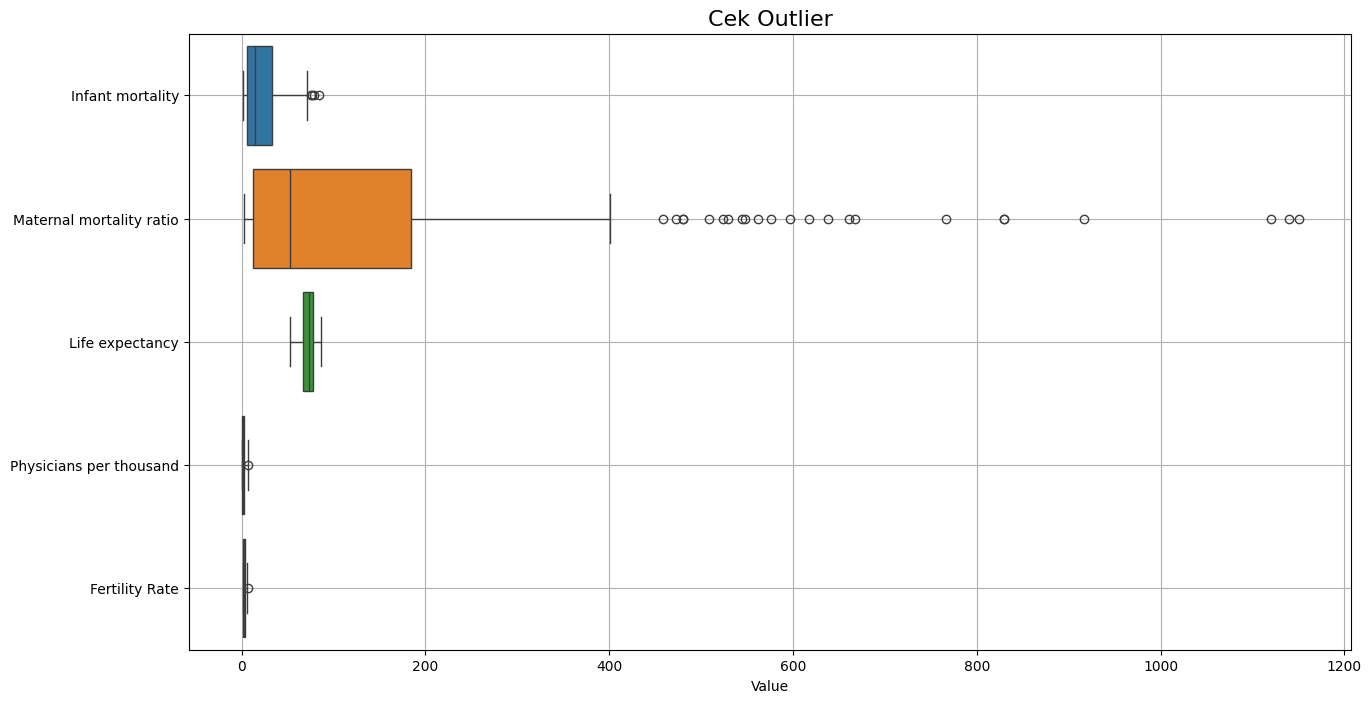

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = ['Infant mortality', 'Maternal mortality ratio', 'Life expectancy', 'Physicians per thousand', 'Out of pocket health expenditure', 'Fertility Rate']
plt.figure(figsize=(15, 8))
sns.boxplot(data=data[columns], orient="h")
plt.title('Cek Outlier', fontsize=16)
plt.xlabel('Value')
plt.grid(True)
plt.show()

In [ ]:
data.head(149)

,Country,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
0,Afghanistan,4.47,47.9,64.5,638.0,78.40%,0.28
1,Albania,1.62,7.8,78.5,15.0,56.90%,1.20
2,Algeria,3.02,20.1,76.7,112.0,28.10%,1.72
3,Andorra,1.27,2.7,84.0,11.2,36.40%,3.33
4,Angola,5.52,51.6,60.8,241.0,33.40%,0.21
...,...,...,...,...,...,...,...
144,Seychelles,2.41,12.4,72.8,53.0,2.50%,0.95
145,Sierra Leone,4.26,78.5,54.3,1120.0,38.20%,0.03
146,Singapore,1.14,2.3,83.1,8.0,36.70%,2.29
147,Slovakia,1.52,4.6,77.2,5.0,18.40%,3.42


In [ ]:
data['Out of pocket health expenditure'] = data['Out of pocket health expenditure'].str.replace('%', '').astype(float) / 100
data
data.to_excel('data_hasil_processing.xlsx', index=False)

In [ ]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

country_name = data['Country']
selected_columns = [
     'Fertility Rate',
    'Infant mortality',
      'Life expectancy',
    'Maternal mortality ratio',
    'Out of pocket health expenditure',
    'Physicians per thousand',
]

data = data[selected_columns]
scaler = RobustScaler()
scaled_array = scaler.fit_transform(data)
data = pd.DataFrame(scaled_array, columns=selected_columns)
data.to_csv('data_normalisasi.csv', index=False)

In [ ]:
data.describe()

,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
count,186.000000,186.000000,186.000000,186.000000,186.000000,1.860000e+02
mean,0.234084,0.277686,-0.109505,0.607365,0.054850,1.615866e-01
std,0.678108,0.732732,0.715352,1.341457,0.721060,6.242766e-01
min,-0.674603,-0.469711,-1.952830,-0.292754,-1.176582,-5.279383e-01
25%,-0.296296,-0.297297,-0.617925,-0.234783,-0.517469,-4.094412e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,4.336809e-17
75%,0.703704,0.702703,0.382075,0.765217,0.482531,5.905588e-01
max,2.462963,2.628145,1.216981,6.362319,1.898017,2.211946e+00


In [ ]:
data

,Fertility Rate,Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
0,1.171958,1.263747,-0.849057,3.394203,1.777148,-0.423892
1,-0.335979,-0.231128,0.471698,-0.217391,0.965061,-0.069364
2,0.404762,0.227400,0.301887,0.344928,-0.122757,0.131021
3,-0.521164,-0.421249,0.990566,-0.239420,0.190746,0.751445
4,1.727513,1.401678,-1.198113,1.092754,0.077432,-0.450867
...,...,...,...,...,...,...
181,0.007937,0.275862,-0.132075,0.420290,0.545798,0.208092
182,-0.108466,0.093197,0.169811,-0.055072,0.458924,-0.215800
183,0.812169,1.077353,-0.698113,0.646377,1.875354,-0.412331
184,1.256614,0.984157,-0.943396,0.930435,-0.145420,-0.073218


# Model Development

In [ ]:
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

data_train = data.values

som = MiniSom(x=1, y=3, input_len=6, learning_rate=0.5, sigma=0.01, random_seed=42)

som._weights[0, 0] = data_train[89]
som._weights[0, 1] = data_train[52]
som._weights[0, 2] = data_train[106] + np.array([0.00, -0.1, 0.7, -0.35, 0.3, -0.05]) # narik


num_iteration = 80
som.train(data_train, num_iteration)

clusters = np.array([som.winner(d)[1] for d in data_train])

silhouette = silhouette_score(data_train, clusters)
dbi = davies_bouldin_score(data_train, clusters)
ch = calinski_harabasz_score(data_train, clusters)

print("Hasil Clustering")
for name, cluster in zip(country_name, clusters):
    print(f"{name}: Cluster {cluster}")

print("\nSilhouette Score:", silhouette)
print("Davies-Bouldin Index:", dbi)
print("Calinski-Harabasz Index:", ch)


Hasil Clustering
Afghanistan: Cluster 0
Albania: Cluster 1
Algeria: Cluster 1
Andorra: Cluster 2
Angola: Cluster 0
Antigua and Barbuda: Cluster 1
Argentina: Cluster 1
Armenia: Cluster 1
Australia: Cluster 2
Austria: Cluster 2
Azerbaijan: Cluster 1
Bahrain: Cluster 1
Bangladesh: Cluster 1
Barbados: Cluster 1
Belarus: Cluster 1
Belgium: Cluster 2
Belize: Cluster 1
Benin: Cluster 0
Bhutan: Cluster 1
Bolivia: Cluster 1
Bosnia and Herzegovina: Cluster 1
Botswana: Cluster 1
Brazil: Cluster 1
Brunei: Cluster 1
Bulgaria: Cluster 1
Burkina Faso: Cluster 0
Burundi: Cluster 0
Cambodia: Cluster 1
Cameroon: Cluster 0
Canada: Cluster 2
Cape Verde: Cluster 1
Central African Republic: Cluster 0
Chad: Cluster 0
Chile: Cluster 1
China: Cluster 1
Colombia: Cluster 1
Comoros: Cluster 0
Costa Rica: Cluster 1
Croatia: Cluster 1
Cyprus: Cluster 1
Czech Republic: Cluster 2
Democratic Republic of the Congo: Cluster 0
Denmark: Cluster 2
Djibouti: Cluster 0
Dominica: Cluster 1
Dominican Republic: Cluster 1
East 

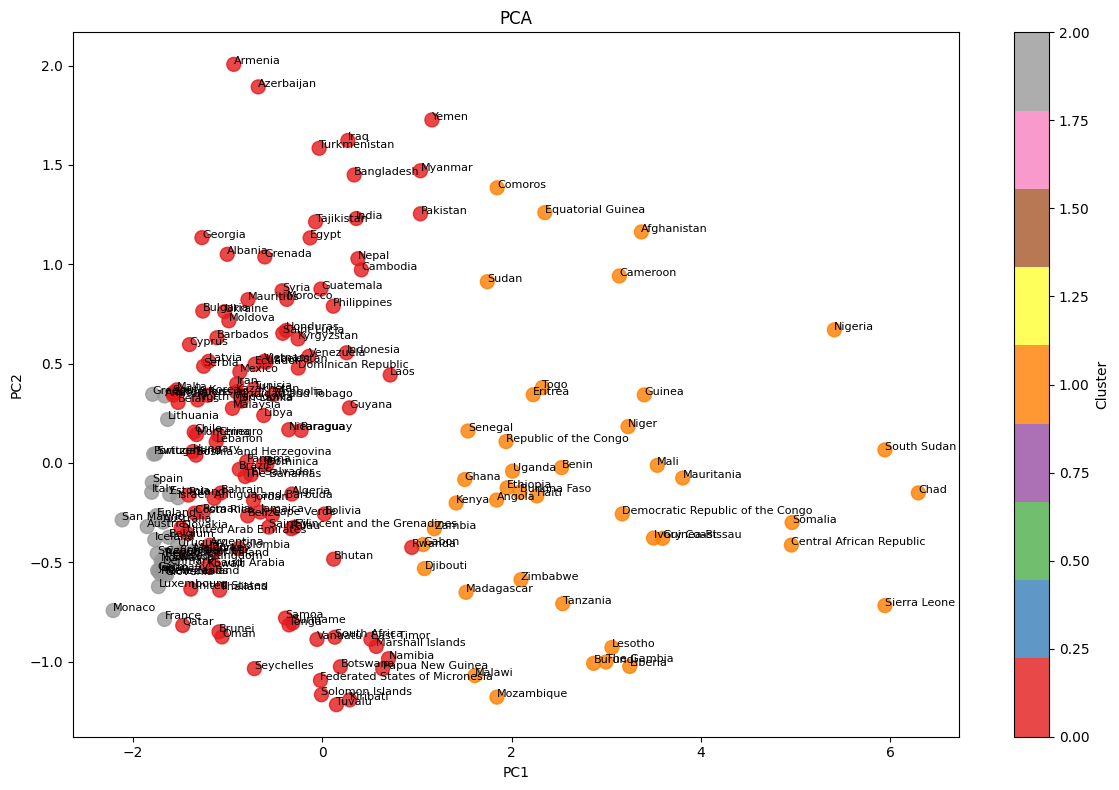

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_train)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='Set1', s=100, alpha=0.8)
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i, name in enumerate(country_name):
    plt.text(data_pca[i, 0], data_pca[i, 1], name, fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

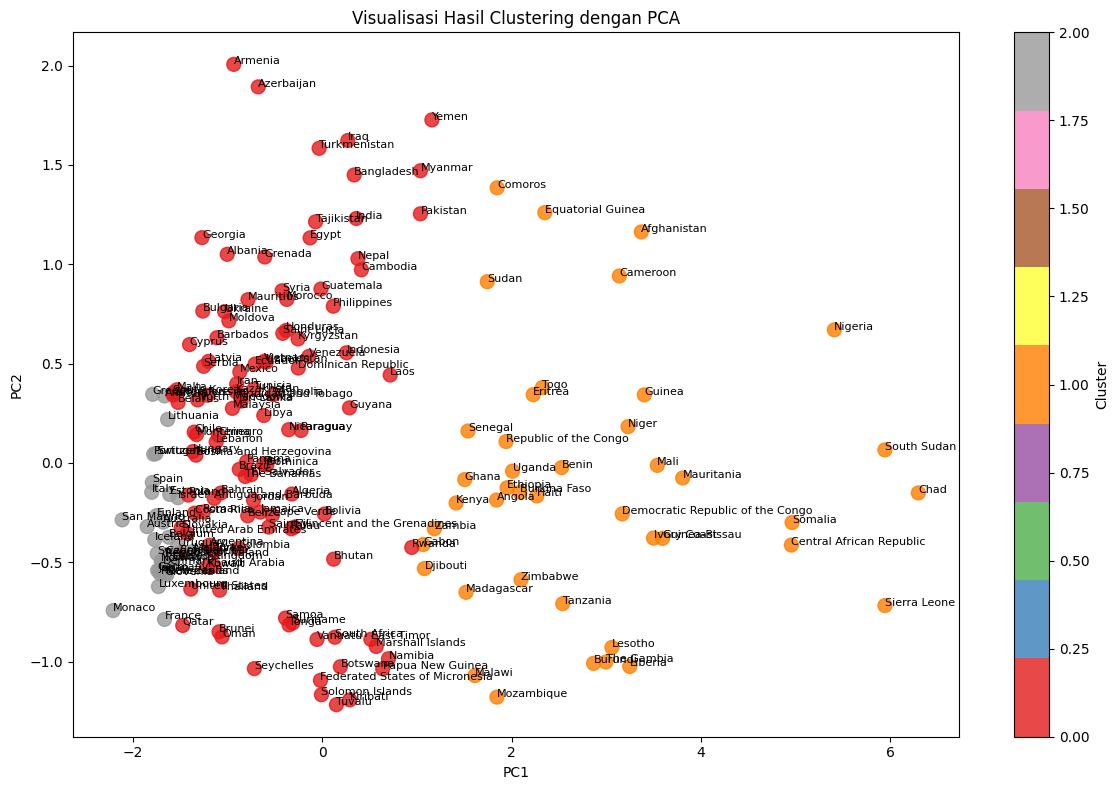

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_train)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='Set1', s=100, alpha=0.8)
plt.title('Visualisasi Hasil Clustering dengan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i, name in enumerate(country_name):
    plt.text(data_pca[i, 0], data_pca[i, 1], name, fontsize=8)

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()
